<a href="https://colab.research.google.com/github/Deepak-Mewada/NMA-CN/blob/main/MDG_load_stringer_orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
dat['istim'] = dat['istim']-(dat['istim']>np.pi)*np.pi
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


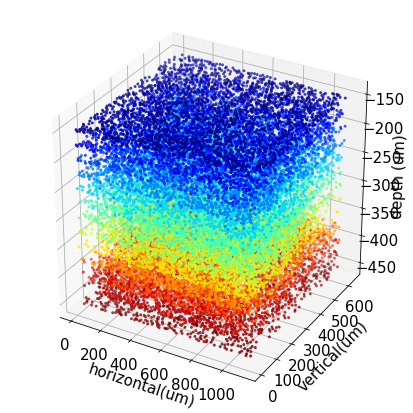

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

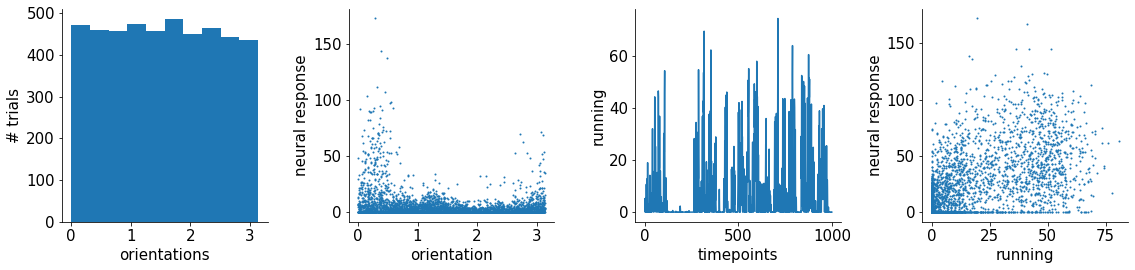

In [ ]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

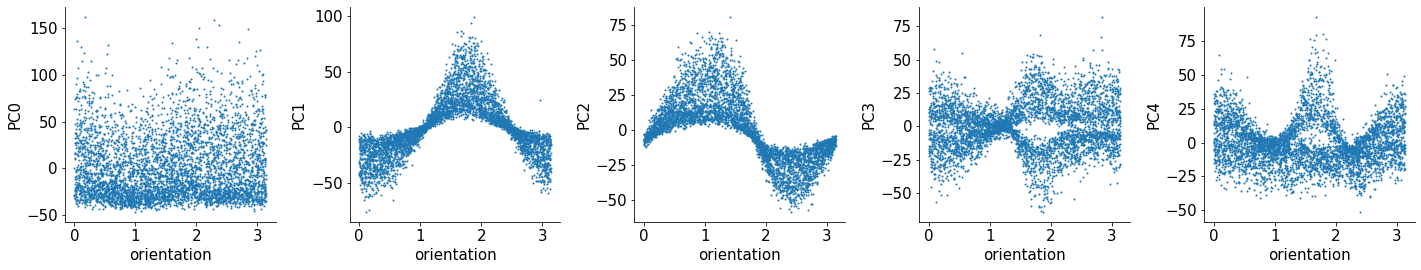

In [ ]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [ ]:
import pandas as pd
from tqdm.notebook import trange

def calculate_orientation_response_curve(neuron_response, orientations, bins=360, window1=15, window2=5, plot=False):
  df = pd.DataFrame({'orientation':np.floor(orientations/(np.pi*2)*bins), 'response':neuron_response})
  k = (df.groupby('orientation').mean())['response'].to_numpy() - np.mean(neuron_response)
  k = np.convolve(np.ones(window1)/window1, k, mode='same')
  k = np.convolve(np.ones(window2)/window2, k, mode='same')
  k = k/max(k)
  xspace = np.linspace(0, np.pi*2, num=bins, endpoint=False)
  if plot:
    plt.figure(figsize=(8, 8))
    plt.plot(xspace, k)
  return xspace, k

neuron_responses=np.array([calculate_orientation_response_curve(dat['sresp'][i,:], dat['istim'])[1] for i in trange(dat['sresp'].shape[0])])


In [ ]:
def filter_neurons(neuron_responses, std_coeff=2, min_threshold=-0.5):
  std = neuron_responses.std(axis=1)
  max = neuron_responses.max(axis=1)
  min = neuron_responses.min(axis=1)
  return np.logical_and(max > std_coeff * std, min>min_threshold)

mask = filter_neurons(neuron_responses)
mask.sum()

12730

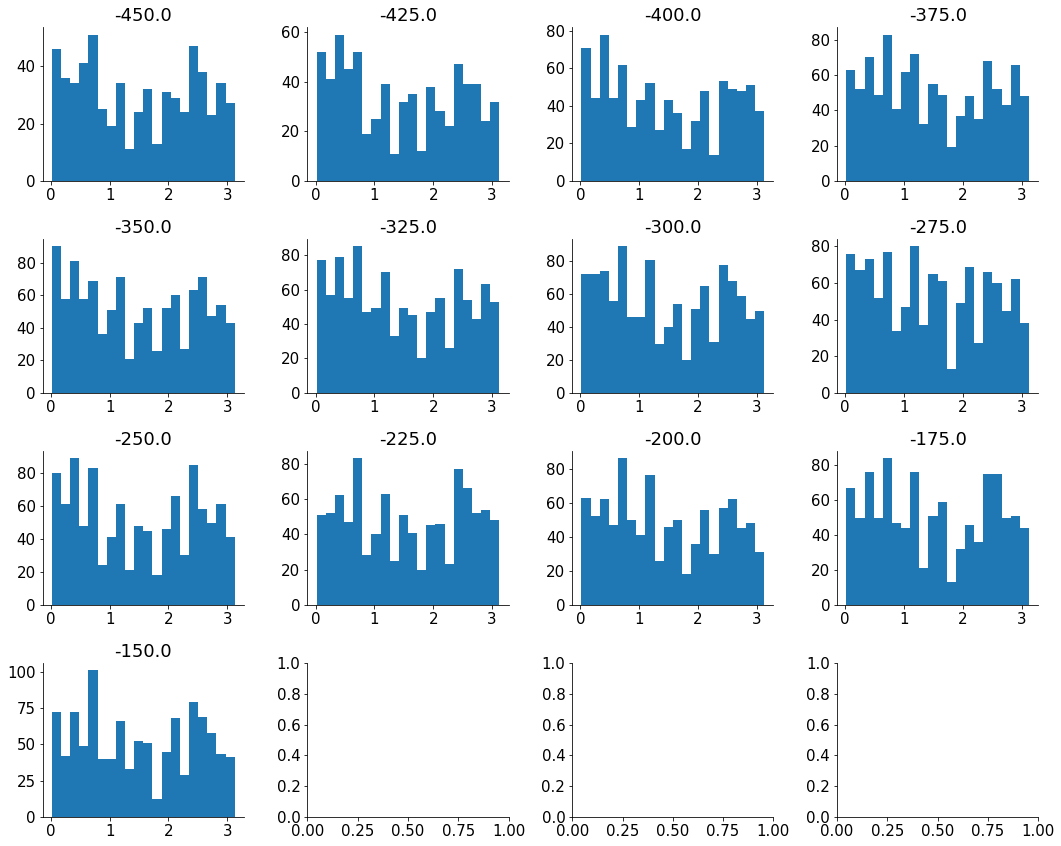

In [ ]:
# Distribution of preferred orientations for each layer
def calculate_orientation_selectivity(neuron_responses, orientations):
  preferred_orientations=orientations[neuron_responses.argmax(axis=1)]
  #preferred_orientations=preferred_orientations-(preferred_orientations>np.pi)*np.pi
  return preferred_orientations

preferred_orientations=calculate_orientation_selectivity(neuron_responses, dat['istim'])
xyz = dat['xyz'][:,mask]
layer_values = np.sort(list(set(z)))

plt.rcParams['figure.figsize'] = (15,12)
fig, axs = plt.subplots(4,4)
layer = 0
for i in trange(4):
  for j in range(4):
    if layer > 12:
      break
    layer_mask = xyz[2,:]==layer_values[layer]
    #for _ in range(100):
      #axs[i,j].hist(np.random.choice(preferred_orientations[mask][layer_mask], layer_mask.sum()), bins=20, alpha=0.5, color='C1')
    axs[i,j].hist(preferred_orientations[mask][layer_mask], bins=20)
    axs[i,j].title.set_text(str(layer_values[layer]))
    layer+=1

(array([ 72.,  42.,  72.,  49., 101.,  40.,  40.,  66.,  33.,  52.,  51.,
         12.,  45.,  68.,  29.,  79.,  69.,  58.,  43.,  41.]),
 array([0.0180348 , 0.17337164, 0.32870848, 0.48404532, 0.63938216,
        0.794719  , 0.95005585, 1.10539269, 1.26072953, 1.41606637,
        1.57140321, 1.72674005, 1.88207689, 2.03741374, 2.19275058,
        2.34808742, 2.50342426, 2.6587611 , 2.81409794, 2.96943479,
        3.12477163]),
 <a list of 20 Patch objects>)

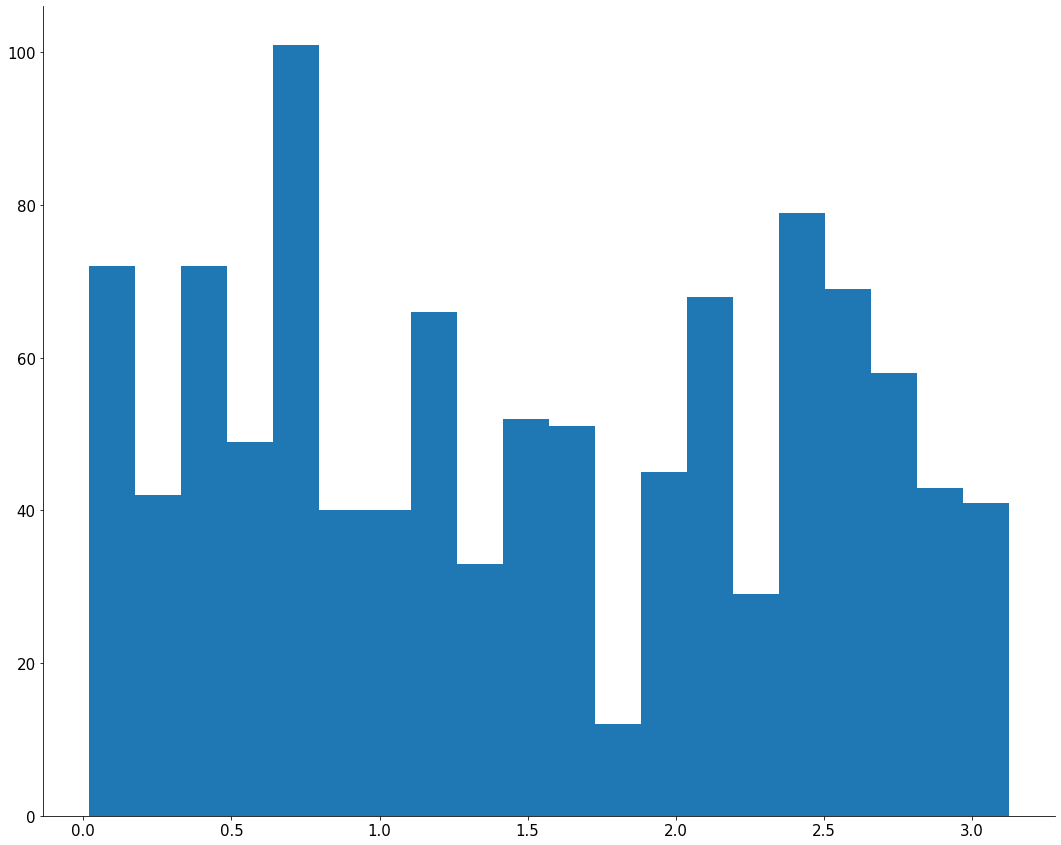

In [ ]:
preferred_orientations=calculate_orientation_selectivity(neuron_responses, dat['istim'])
xyz = dat['xyz'][:,mask]
layer_values = np.sort(list(set(z)))

plt.rcParams['figure.figsize'] = (15,12)
layer = 0
plt.hist(preferred_orientations[mask][layer_mask], bins=20)

<BarContainer object of 24 artists>

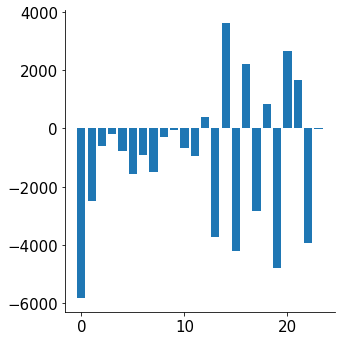

In [ ]:
from sklearn.mixture import GaussianMixture

layer_mask = xyz[2,:]==layer_values[0]

aics=[]
for n in trange(1,26):
  gm = GaussianMixture(n_components=n)
  gm.fit(preferred_orientations[mask].reshape(-1,1))
  aics.append(gm.aic(preferred_orientations.reshape(-1,1)))

plt.figure(figsize=(5,5))
plt.bar(range(len(aics)-1), np.diff(aics))

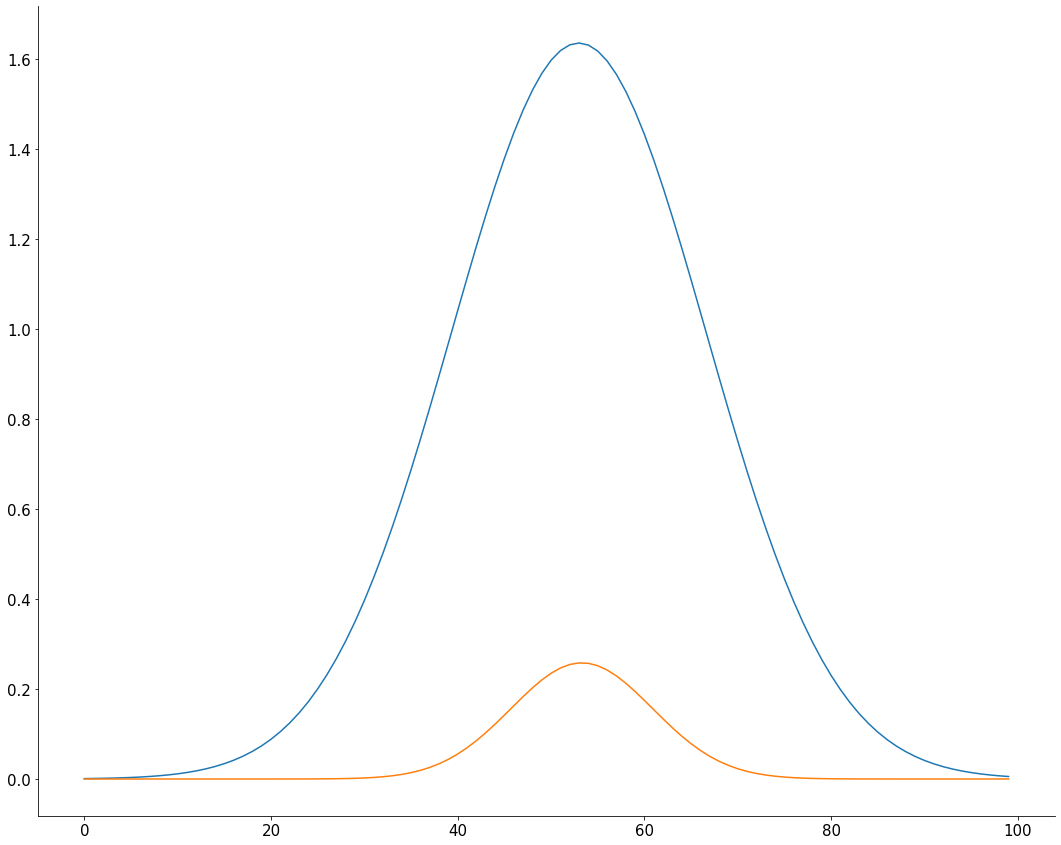

(array([[0.73101602],
        [2.36766622]]), array([[[0.21016499]],
 
        [[0.2295859 ]]]))

In [ ]:
gm = GaussianMixture(n_components=2)
gm.fit(preferred_orientations[mask].reshape(-1,1))

def gaussian(x, alpha, r):
  return 1./(np.sqrt(alpha**np.pi))*np.exp(-alpha*np.power((x - r), 2.))

x = np.linspace(-3, 3, 100)
plt.plot(gaussian(x,gm.means_[0][0], gm.covariances_[0][0]))
plt.plot(gaussian(x,gm.means_[1][0], gm.covariances_[1][0]))

plt.show()

gm.means_, gm.covariances_

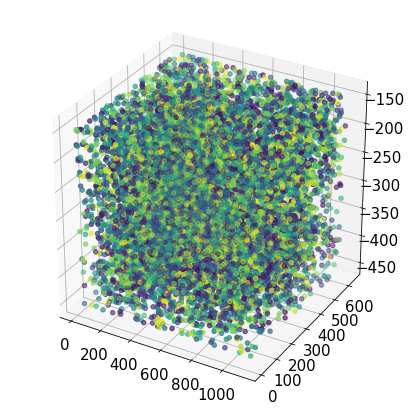

In [ ]:
x, y, z = dat['xyz'][0,:][mask], dat['xyz'][1,:][mask], dat['xyz'][2,:][mask]
po = preferred_orientations[mask]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=po)

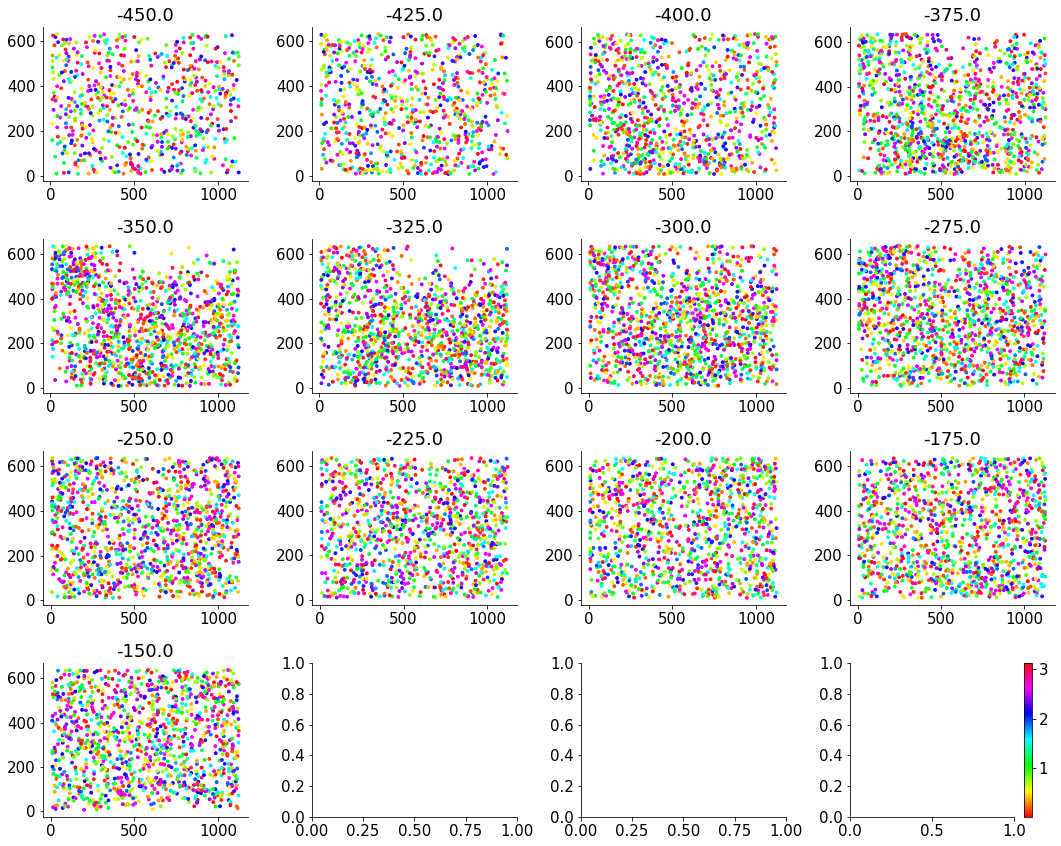

In [ ]:
# Plot preferred orientations for each layer
x, y, z = dat['xyz'][0,:][mask], dat['xyz'][1,:][mask], dat['xyz'][2,:][mask]
po = preferred_orientations[mask]

layer_values = np.sort(list(set(z)))

plt.rcParams['figure.figsize'] = (15,12)
fig, axs = plt.subplots(4,4)
layer = 0
for i in range(4):
  for j in range(4):
    layer_mask = z==layer_values[layer]
    ax=axs[i,j].scatter(x[layer_mask], y[layer_mask], c=po[layer_mask], cmap=cm.hsv, s=8)
    axs[i,j].title.set_text(str(layer_values[layer]))
    layer+=1
    if layer > 12:
      fig.colorbar(ax)
      break



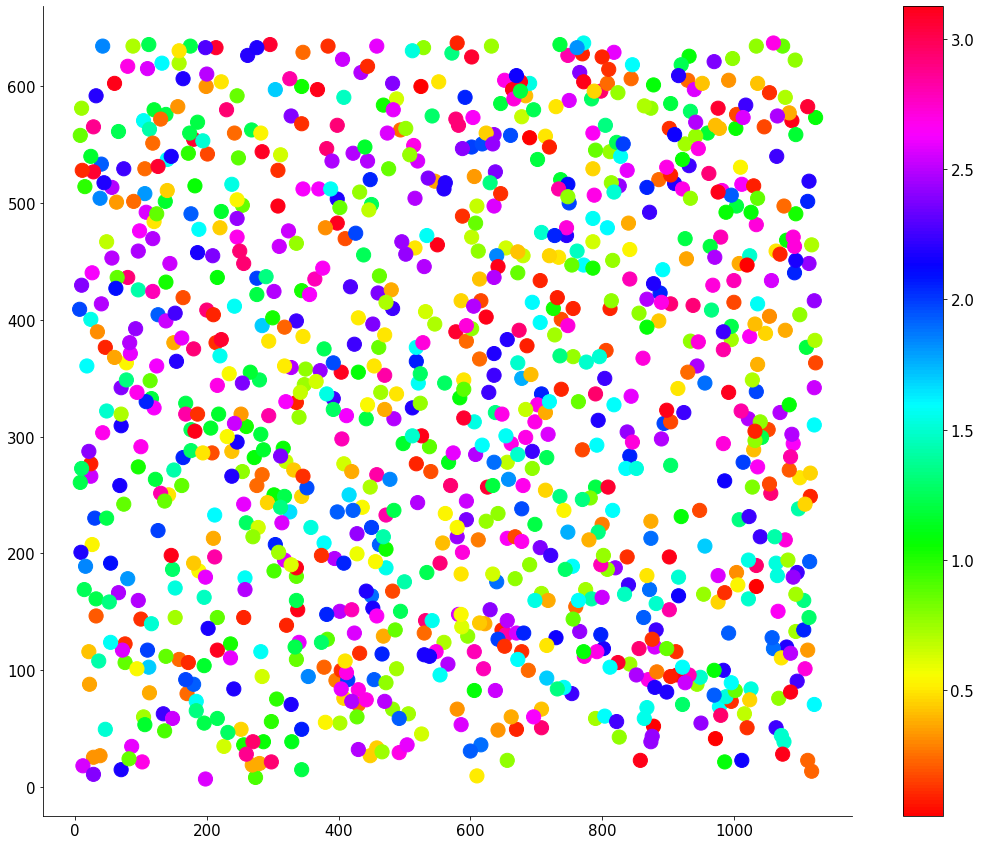

In [ ]:
# Plot preferred orientations for each layer
x, y, z = dat['xyz'][0,:][mask], dat['xyz'][1,:][mask], dat['xyz'][2,:][mask]
po = preferred_orientations[mask]

layer_values = np.sort(list(set(z)))

plt.rcParams['figure.figsize'] = (15,12)
layer = 0
plt.scatter(x[layer_mask], y[layer_mask], c=po[layer_mask], cmap=cm.hsv, s=200)
plt.colorbar()

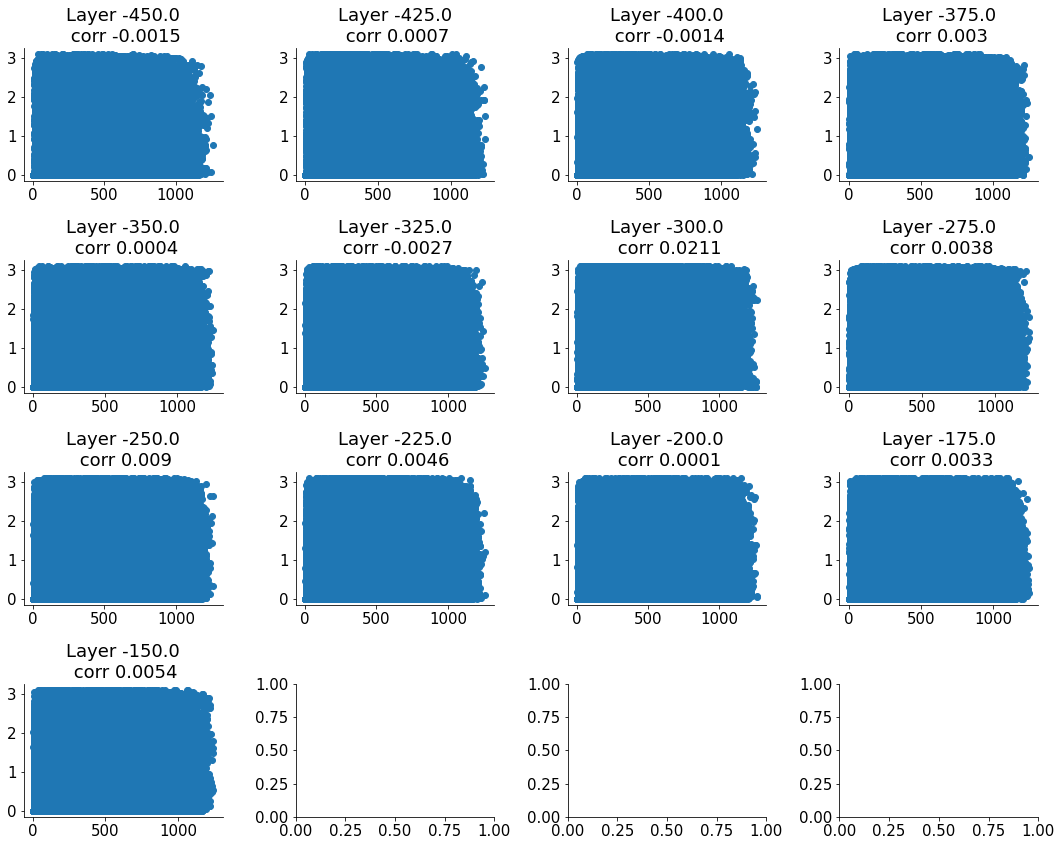

In [ ]:
# quantify clustering
def quantify_clustering(xyz, preferred_orientations):
  distances = []
  or_similarities = []
  for i in range(xyz.shape[1]):
    for j in range(i,xyz.shape[1]):
      i_pos, j_pos = xyz[:,i], xyz[:,j]
      distances.append(np.linalg.norm(i_pos-j_pos))
      or_similarities.append(np.abs(preferred_orientations[i]-preferred_orientations[j]))
  return np.array(distances), np.array(or_similarities)



xyz = dat['xyz'][:,mask]
layer_values = np.sort(list(set(z)))

plt.rcParams['figure.figsize'] = (15,12)
fig, axs = plt.subplots(4,4)
layer = 0
for i in trange(4):
  for j in range(4):
    if layer > 12:
      break
    layer_mask = xyz[2,:]==layer_values[layer]
    distances, orientation_similarities = quantify_clustering(xyz[:,layer_mask], preferred_orientations[mask][layer_mask])
    
    axs[i,j].scatter(distances, orientation_similarities)
    axs[i,j].title.set_text('Layer {}\n corr {}'.format(layer_values[layer], np.round_(np.corrcoef(distances, orientation_similarities)[0,1], 4)))
    layer+=1


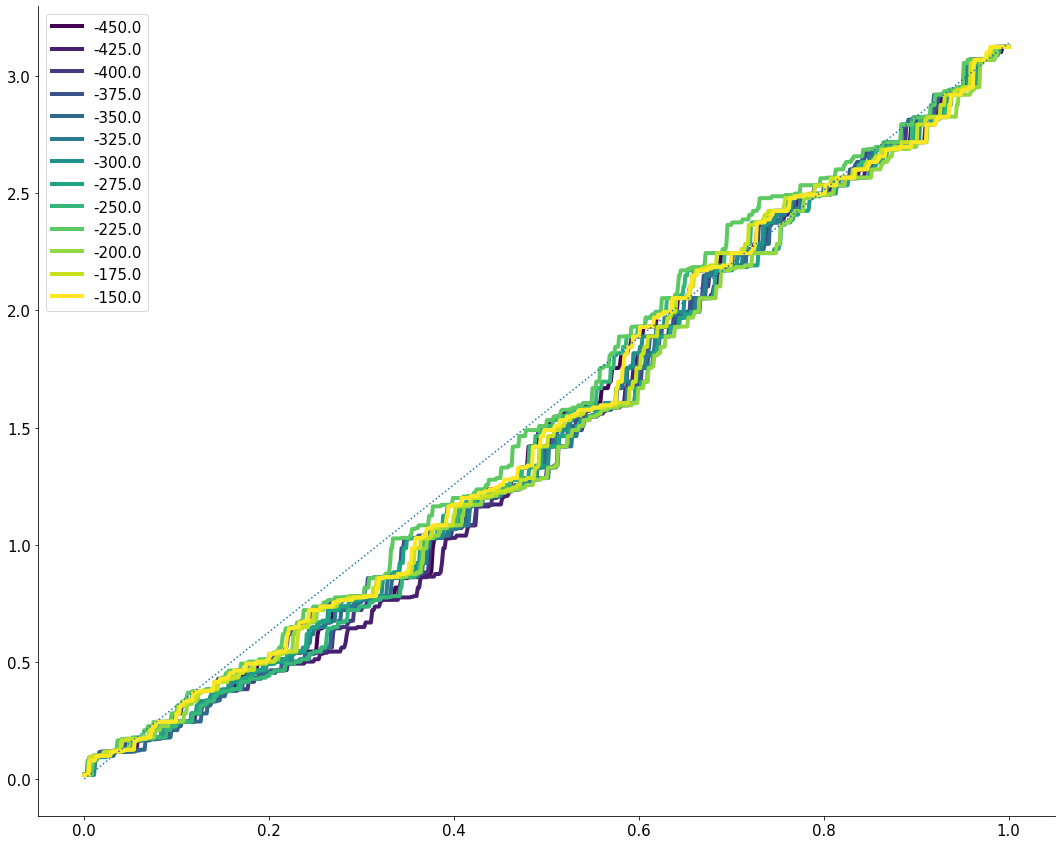

In [ ]:
# Compare distribution of preferred orientations between layers
import matplotlib.cm as cm

layer_values = np.sort(list(set(z)))
colors = cm.viridis(np.linspace(0,1,len(layer_values)))

layer = 0

for i in trange(4):
  for j in range(4):
    if layer > 12:
      break
    layer_mask = xyz[2,:]==layer_values[layer]
    sorted_os = np.sort(preferred_orientations[mask][layer_mask])
    x = np.linspace(0,1,sorted_os.shape[0])
    plt.plot(x, sorted_os, color=colors[layer], label=str(layer_values[layer]), linewidth=4)
    layer+=1

plt.plot([0,1], [0,np.pi], linestyle='dotted')
plt.legend()

### **To do:**
- Subtract pi prior to calculation orientation selectivities - DONE
- Adjust filtering - DONE
- Bootstrap + ~~dip test~~ Gaussian mixture for histograms - DONE
- Check what grating orientation each angle corresponds to -> 0/pi is vertical lines - DONE
- Add colorbars - DONE
- Find better angle metric 
- New way to quantify clustering
- Randomly sample columns of increasing radius and plot radius vs within column similarity
- Cross correlation for comparing layers
- Sliding bar with binning means across euclidean distance v similarity

In [ ]:
import matplotlib.cm as cm
colormap=cm.twilight_r
l150=tmp_array[tmp_array[:, 3]==250]
plt.figure(figsize=(8, 8))
plt.quiver(l150[:, 1],l150[:, 2],np.cos(l150[:, 0]), np.sin(l150[:, 0]), color=colormap(l150[:, 0]/np.pi/2), headaxislength=0, pivot='middle', headwidth=1)
plt.show()

NameError: ignored